## Water CNN Trained

In [40]:
import os, json
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

## 1.Image folder with subfolders for each class 

In [41]:
DATA_DIR = "water images"   # Replace with your extracted folder name
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
VALID_SPLIT = 0.2  

## 2.Load image datasets

In [42]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    DATA_DIR,
    validation_split=VALID_SPLIT,
    subset="training",
    label_mode="categorical",
    seed=123,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    DATA_DIR,
    validation_split=VALID_SPLIT,
    subset="validation",
    label_mode="categorical",
    seed=123,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE)

class_names = train_ds.class_names
num_classes = len(class_names)
print("Classes:", class_names)

Found 61 files belonging to 2 classes.
Using 49 files for training.
Found 61 files belonging to 2 classes.
Using 12 files for validation.
Classes: ['test', 'train']


## 3.Show sample images from training set

 Sample images from training set


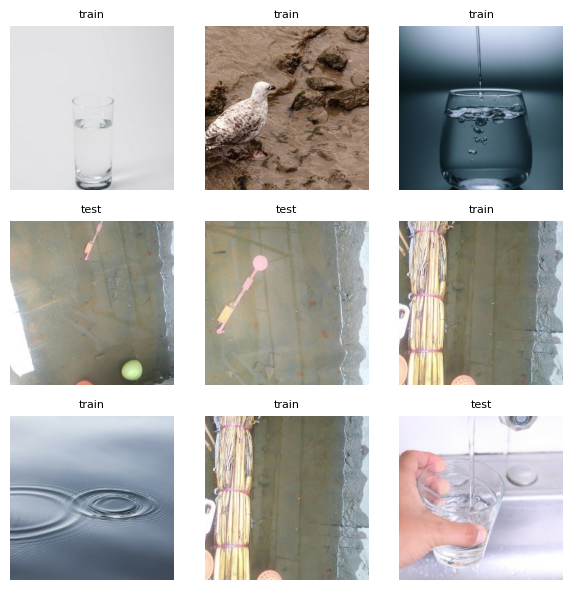

In [43]:
def show_batch(dataset, n=9):
    plt.figure(figsize=(6, 6))
    for images, labels in dataset.take(1):
        for i in range(n):
            ax = plt.subplot(int(np.sqrt(n)), int(np.sqrt(n)), i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(class_names[np.argmax(labels[i])], fontsize=8)
            plt.axis("off")
    plt.tight_layout()
    plt.show()

print(" Sample images from training set")
show_batch(train_ds)


## 4.Performance tuning 

In [44]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## 5.Build model (MobileNetV2 + head) 

In [45]:
base_model = tf.keras.applications.MobileNetV2(
    input_shape=IMG_SIZE + (3,),
    include_top=False,
    weights="imagenet")
base_model.trainable = False

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1)
])

## 6.Show augmented images

 Data-augmentation preview


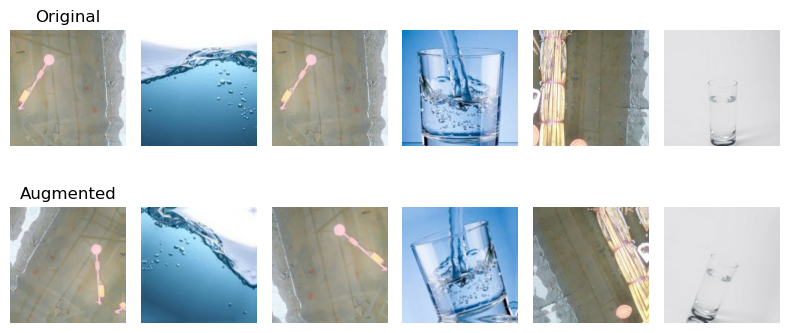

In [46]:
def show_augmented(dataset, n=6):
    images, _ = next(iter(dataset.take(1)))
    aug_images = data_augmentation(images)
    
    plt.figure(figsize=(8, 4))
    for i in range(n):
        # original
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.axis("off")
        if i == 0: ax.set_title("Original")
        # augmented
        ax = plt.subplot(2, n, i + n + 1)
        plt.imshow(aug_images[i].numpy().astype("uint8"))
        plt.axis("off")
        if i == 0: ax.set_title("Augmented")
    plt.tight_layout()
    plt.show()

print(" Data-augmentation preview")
show_augmented(train_ds)

inputs = layers.Input(shape=IMG_SIZE + (3,))
x = data_augmentation(inputs)
x = tf.keras.applications.mobilenet_v2.preprocess_input(x)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)

model = models.Model(inputs, outputs)
model.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
              loss="categorical_crossentropy",
              metrics=["accuracy"])


## 7.Train initial model

In [47]:
EPOCHS = 20
callbacks = [
    ModelCheckpoint("best_water_cnn.h5", monitor="val_accuracy", save_best_only=True, verbose=1),
    EarlyStopping(monitor="val_accuracy", patience=5, restore_best_weights=True)
]

history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=EPOCHS,
                    callbacks=callbacks)

Epoch 1/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.3896 - loss: 0.9948  
Epoch 1: val_accuracy improved from -inf to 0.91667, saving model to best_water_cnn.h5


2/2 ━━━━━━━━━━━━━━━━━━━━ 22s 12s/step - accuracy: 0.3822 - loss: 1.0229 - val_accuracy: 0.9167 - val_loss: 0.4207
Epoch 2/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6859 - loss: 0.8112
Epoch 2: val_accuracy did not improve from 0.91667
2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 3s/step - accuracy: 0.6750 - loss: 0.8388 - val_accuracy: 0.9167 - val_loss: 0.2480
Epoch 3/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6014 - loss: 0.9980   
Epoch 3: val_accuracy did not improve from 0.91667
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.6255 - loss: 0.9117 - val_accuracy: 0.9167 - val_loss: 0.2457
Epoch 4/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 699ms/step - accuracy: 0.7274 - loss: 0.6565
Epoch 4: val_accuracy did not improve from 0.91667
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - accuracy: 0.7094 - loss: 0.7036 - val_accuracy: 0.9167 - val_loss: 0.2605
Epoch 5/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 954ms/step - accuracy: 0.6615 - loss: 0.8955
Epoch 5: val_accuracy did not improve from 0.91667
2/2 ━━━━━━━━

## 8.Fine-tune (unfreeze part of base model)

In [48]:
base_model.trainable = True
fine_tune_at = 100
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
              loss="categorical_crossentropy",
              metrics=["accuracy"])

fine_history = model.fit(train_ds,
                         validation_data=val_ds,
                         epochs=EPOCHS,
                         callbacks=callbacks)


Epoch 1/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.4712 - loss: 0.8045  
Epoch 1: val_accuracy did not improve from 0.91667
2/2 ━━━━━━━━━━━━━━━━━━━━ 47s 9s/step - accuracy: 0.4910 - loss: 0.7796 - val_accuracy: 0.9167 - val_loss: 0.3678
Epoch 2/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5810 - loss: 0.6474
Epoch 2: val_accuracy did not improve from 0.91667
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - accuracy: 0.5982 - loss: 0.6386 - val_accuracy: 0.9167 - val_loss: 0.3220
Epoch 3/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7689 - loss: 0.4458   
Epoch 3: val_accuracy did not improve from 0.91667
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 2s/step - accuracy: 0.7507 - loss: 0.4649 - val_accuracy: 0.9167 - val_loss: 0.3310
Epoch 4/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8007 - loss: 0.3471   
Epoch 4: val_accuracy did not improve from 0.91667
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 2s/step - accuracy: 0.8127 - loss: 0.3563 - val_accuracy: 0.8333 - val_loss: 0.3579
Epoch 5/20
2/2 

## 9.Plot training history 

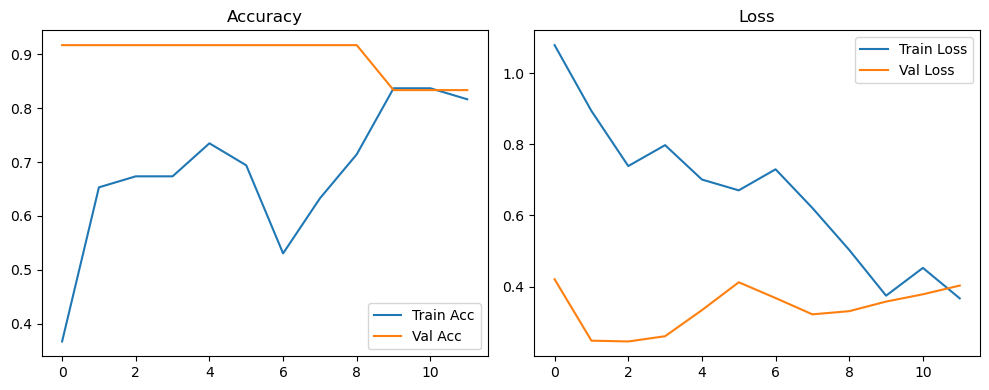


 Curve saved as training_curves.png


In [49]:
def plot_history(hist, fine_hist, out_png="training_curves.png"):
    acc  = hist.history['accuracy'] + fine_hist.history['accuracy']
    val  = hist.history['val_accuracy'] + fine_hist.history['val_accuracy']
    loss = hist.history['loss'] + fine_hist.history['loss']
    vlos = hist.history['val_loss'] + fine_hist.history['val_loss']

    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(acc, label='Train Acc')
    plt.plot(val, label='Val Acc')
    plt.title('Accuracy'); plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(loss, label='Train Loss')
    plt.plot(vlos, label='Val Loss')
    plt.title('Loss'); plt.legend()

    plt.tight_layout()
    plt.savefig(out_png)
    plt.show()
    print(f"\n Curve saved as {out_png}")

plot_history(history, fine_history)


## 10.Show predictions vs. ground truth

Model predictions on a validation batch
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


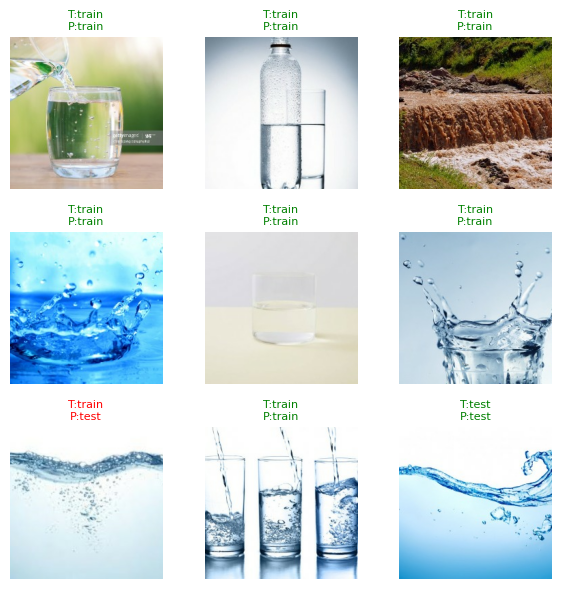

In [50]:
def show_predictions(model, dataset, n=9):
    images, labels = next(iter(dataset.take(1)))
    preds = model.predict(images)

    plt.figure(figsize=(6, 6))
    for i in range(n):
        ax = plt.subplot(int(np.sqrt(n)), int(np.sqrt(n)), i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        true_cls = class_names[np.argmax(labels[i])]
        pred_cls = class_names[np.argmax(preds[i])]
        color = "green" if true_cls == pred_cls else "red"
        ax.set_title(f"T:{true_cls}\nP:{pred_cls}", color=color, fontsize=8)
        plt.axis("off")
    plt.tight_layout()
    plt.show()

print("Model predictions on a validation batch")
show_predictions(model, val_ds)

## 11.Save model & label mapping

In [51]:
FINAL_MODEL = "water_cnn_final.h5"
model.save(FINAL_MODEL)

with open("class_indices.json", "w") as f:
    json.dump({i: c for i, c in enumerate(class_names)}, f)

print("\n Training complete!")
print(f"Model: {FINAL_MODEL}")
print(f"Class map: class_indices.json")
print(f"Graph: training_curves.png")


 Training complete!
Model: water_cnn_final.h5
Class map: class_indices.json
Graph: training_curves.png
